In [1]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import math
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn.parameter import Parameter
import torchvision.models as models
import torch.nn.functional as F
from data_loader import LandmarksDataset, GrayscaleToRGB
from model import LandmarkModel, ArcMarginProduct, SimpleFC
import torchvision.utils as vutils
from batchHardTripletSelector import BatchHardTripletSelector, pdist
from visdom import Visdom
import IPython

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
load_path = "saved_models/cub/iter2/model_128.pth"
images_dir = "../data/CUB_200_2011/images"
image_size = 224
train_files = "../data/CUB_200_2011/train2.csv"
embd_path = "train_embds2.npy"

In [7]:
def extract_feature_discriptors():

    landmarkModel = LandmarkModel().to(device)
    landmarkModel.eval()
    checkpoint = torch.load(load_path)
    landmarkModel.load_state_dict(checkpoint['model_state_dict'])
    with open(train_files,'r') as f:
        lines = f.readlines()

    transform_list = [
      transforms.Resize(image_size),
      transforms.CenterCrop(image_size),
      transforms.ToTensor(),
      GrayscaleToRGB(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ]

    transform = transforms.Compose(transform_list)

    image_embds = []
    for line in tqdm(lines, total=len(lines)):
        line = line.strip().split(',')
        images = line[1].split()
        for img in images:
            img_path = os.path.join(images_dir, img)
            image_tensor = transform(Image.open(img_path)).unsqueeze(0).to(device)
            embd = landmarkModel(image_tensor).squeeze()
            image_embds.append((img,embd.detach().cpu().numpy()))

    np.save(embd_path,image_embds)

In [9]:
extract_feature_discriptors()

100%|██████████| 200/200 [02:27<00:00,  1.35it/s]

9465


In [7]:
test_img_path = "download.jpeg"

In [8]:
def get_topk_matches(k=5):

    print("Loading trained model from {}".format(load_path))
    landmarkModel = LandmarkModel().to(device)
    print("Loaded trained model")
    landmarkModel.eval()
    checkpoint = torch.load(load_path)
    landmarkModel.load_state_dict(checkpoint['model_state_dict'])

    transform_list = [
      transforms.Resize(image_size),
      transforms.CenterCrop(image_size),
      transforms.ToTensor(),
      GrayscaleToRGB(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ]

    transform = transforms.Compose(transform_list)

    train_image_embds = np.load(embd_path, allow_pickle=True)
    image_tensor = transform(Image.open(test_img_path)).unsqueeze(0).to(device)
    test_img_embd = landmarkModel(image_tensor).squeeze().detach().cpu().numpy()

    dist_vec = []
    for img in train_image_embds:
        train_img_name = img[0]
        train_img_embd = img[1]
        dist = np.linalg.norm(test_img_embd - train_img_embd)
        dist_vec.append((train_img_name, dist))

    best_matches = sorted(dist_vec, key=lambda x:x[1])[:k]
    
    print('-'*50)
    print('Test Image:')
    IPython.display.display(IPython.display.Image(test_img_path))
    print('-'*50)
    for i in range(k):
        print("Class : {}".format(os.path.dirname(best_matches[i][0][4:])))
        matched_image_path = os.path.join(images_dir, best_matches[i][0])
        IPython.display.display(IPython.display.Image(matched_image_path))
        print('-'*50)

Loading trained model from saved_models/cub/iter2/model_128.pth
Loaded trained model
--------------------------------------------------
Test Image:


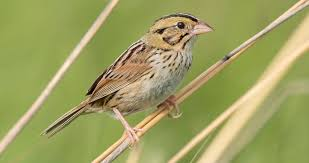

--------------------------------------------------
Class : Henslow_Sparrow


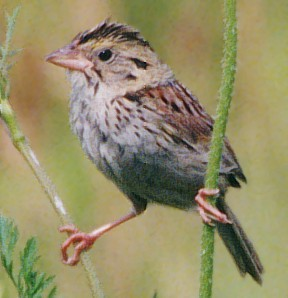

--------------------------------------------------
Class : Henslow_Sparrow


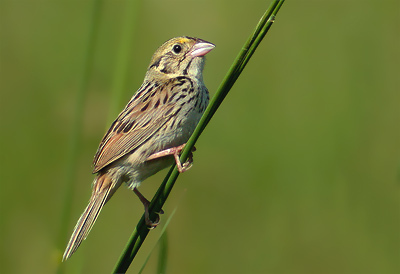

--------------------------------------------------
Class : Henslow_Sparrow


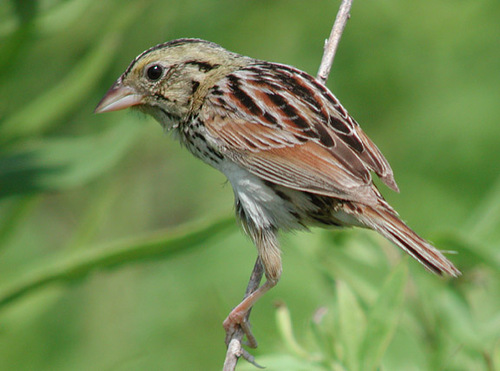

--------------------------------------------------
Class : Henslow_Sparrow


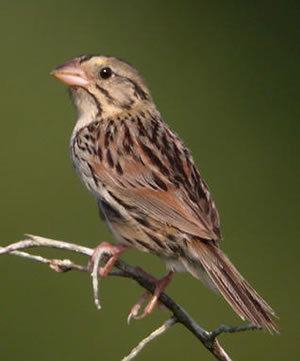

--------------------------------------------------
Class : Henslow_Sparrow


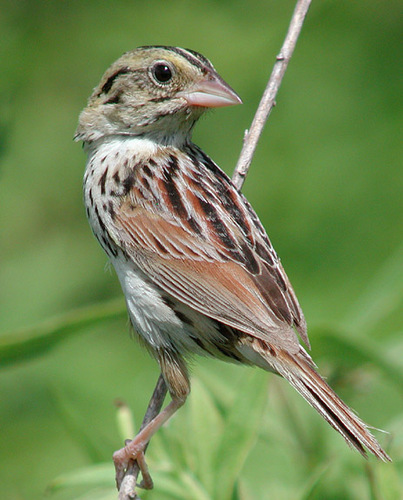

--------------------------------------------------
Class : Henslow_Sparrow


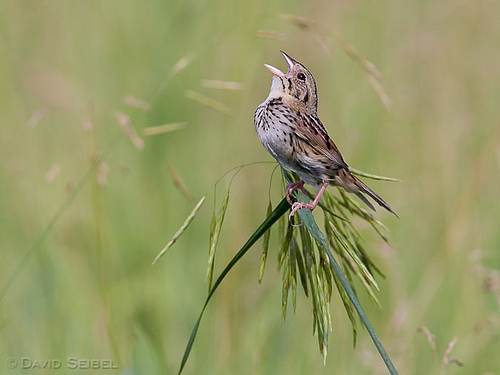

--------------------------------------------------
Class : Henslow_Sparrow


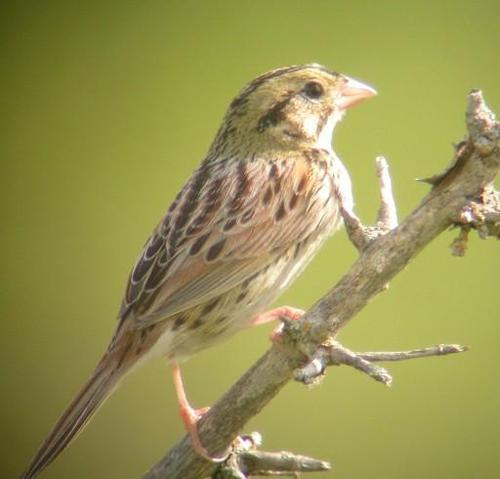

--------------------------------------------------
Class : Henslow_Sparrow


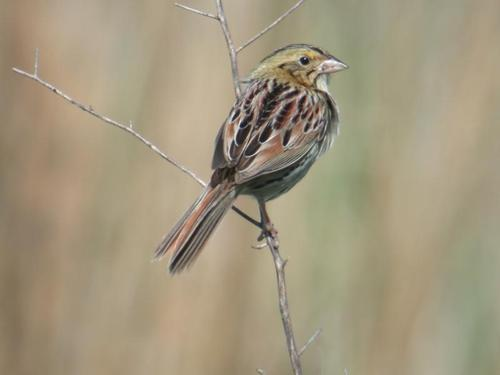

--------------------------------------------------
Class : Henslow_Sparrow


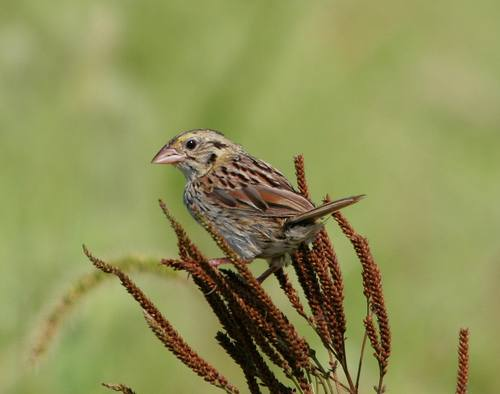

--------------------------------------------------
Class : Henslow_Sparrow


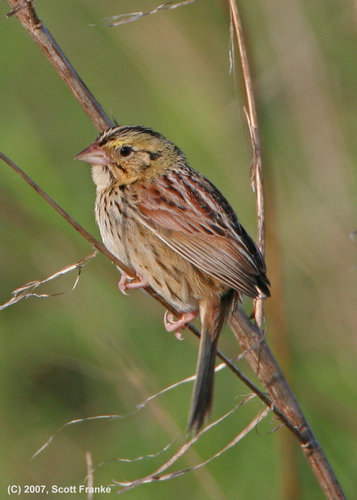

--------------------------------------------------


In [9]:
get_topk_matches(10)